In [1]:
import control as ct
import numpy as np
import time

In [19]:
class RWIPDerivation:

    def __init__(self, method) -> None:

        self.method = method
        # Define LQR weights
        self.phi_penalty = 10000
        self.phidot_penalty = 0.1
        self.thetadot_penalty = 0.015
        self.constant_penalty = 0
        self.torque_penalty = 100

        # Store LQR weights
        self._Q = np.diag(
            [
                self.phi_penalty,
                self.phidot_penalty,
                self.thetadot_penalty,
                self.constant_penalty,
            ]
        )
        self._R = np.array([[self.torque_penalty]])

    def augmented_system_A(self, phi: float) -> np.ndarray:
        """Compute and return the system's augmented A matrix, evaluated numerically."""
        # cos and sin phi
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)

        # eval 4x4 matrix numerically
        A = np.array(
            [
                [0, 1, 0, 0],
                [60.301 * cos_phi, 0, 0, 60.301 * sin_phi],
                [60.301 * cos_phi, 0, 0, 60.301 * sin_phi],
                [0, 0, 0, 1],
            ]
        )

        return A

    def augmented_system_B(self) -> np.ndarray:
        """Return the system's augmented input array B."""
        B = np.array([[0], [53.275], [1432.6], [1]])

        return B

    def compute_lqr_gain(self, X_current):
        """
        Compute the Linear Quadratic Regulator (LQR) gain matrix K for the current state.

        The LQR gain matrix K is computed by linearizing the system dynamics around
        the current state and solving the continuous-time algebraic Riccati equation.

        Parameters:
            X_current : The current state of the system, a vector of the form [phi, dphi, dtheta].
                - phi: Current angle of the pendulum from vertical (radians). Positive CCW
                - dphi: Current angular velocity of the pendulum (radians/second). Positive CCW
                - dtheta: Current angular velocity of the wheel (radians/second). Positive CW

        Returns:
            K : The LQR gain matrix. Used to compute the control input based on the current
                state of the system.
        """
        phi = X_current[0]

        # Convert symbolic matrices to numerical numpy arrays
        A_num = self.augmented_system_A(phi=phi)
        B_num = self.augmented_system_B()

        K, S, E = ct.lqr(A_num, B_num, self._Q, self._R, method=self.method)

        return K.flatten()[:3]
    
    def get_torque(self, state):
        # Robot states vector
        K = self.compute_lqr_gain(np.append(state, 1))

        # Torque computation
        torque = np.dot(K, state)

        # Clamp torque if outside bounds
        if abs(torque) > 0.6:
            torque = 0.6 * (1 if torque > 0 else -1)

        return torque

In [23]:
d = RWIPDerivation(method=None)

times = []

for i in range(1000):
    state = [np.random.normal(0, 0.4), np.random.normal(0, 10), np.random.normal(0, 100)]
    start = time.time()
    t = d.get_torque(state=state)
    end = time.time()
    times.append(end - start)

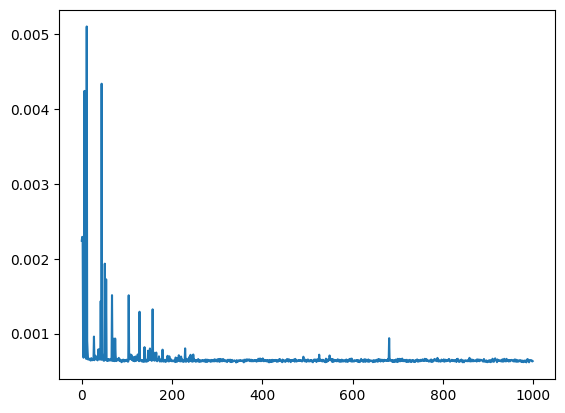

In [24]:
import matplotlib.pyplot as plt

plt.plot(times)

In [26]:
df = RWIPDerivation(method='scipy')

times_f = []

for i in range(1000):
    state = [np.random.normal(0, 0.4), np.random.normal(0, 10), np.random.normal(0, 100)]
    start = time.time()
    t = df.get_torque(state=state)
    end = time.time()
    times_f.append(end - start)

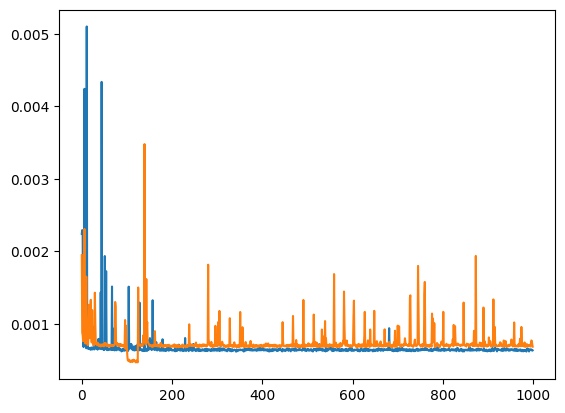

In [27]:
plt.plot(times)
plt.plot(times_f)

In [28]:
print(np.mean(times))
print(np.mean(times_f))

0.0006697444915771485
0.000736975908279419
